In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pyarrow.parquet as pq
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import os

import plotly.graph_objects as go
from astropy.time import Time
from time import time

Lectura de los archivo features_paula y labels_paula

In [15]:

features_paula = pd.read_csv('./datos_exp4/features_paula.csv',index_col='oid')
features_paula = features_paula.drop(['Unnamed: 0'],axis=1)
print(f'total eventos features_paula: {len(features_paula)}')
# -----------
labels_paula = pd.read_csv('./datos_exp4/labels_paula.csv',index_col='oid')
labels_paula = labels_paula.drop(['Unnamed: 0'],axis=1)
print(f'total eventos features_paula: {len(labels_paula)}')

# features_paula.head()
labels_paula.head()

total eventos features_paula: 6909
total eventos features_paula: 6909


,class_original,class_hierachical
oid,,
ZTF17aaaemke,E,Periodic
ZTF17aaafyya,E,Periodic
ZTF17aaageae,RRL,Periodic
ZTF17aaaivsr,E,Periodic
ZTF17aaaizej,RRL,Periodic


Lectura de archivos con las caracteristicas + tensor

In [26]:
folder = './datos_exp4/'
features_4x4x10 = 'features_4x4x10.csv'
features_5x4x5 = 'features_5x4x5.csv'
features_2x4x5 = 'features_2x4x5.csv'

path = folder + features_4x4x10

df_features_tensor = pd.read_csv(path)
df_features_tensor = df_features_tensor.drop(['Unnamed: 0'],axis=1)
print(f'total eventos: {len(df_features_tensor)}')
df_features_tensor.head()

total eventos: 6909


,oid,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,...,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2,Tensor
0,ZTF17aaaemke,0.319945,0.266913,0.999845,0.999997,1.0,1.0,0.361111,0.375000,0.0,...,0.998750,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,1.885743e-06,4.405883e-08,[ 1.65146666e+01 -1.00000000e+03 1.64708068e+...
1,ZTF17aaafyya,0.376849,0.347666,1.000000,1.000000,1.0,1.0,0.421875,0.388889,0.0,...,0.996250,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,2.254299e-06,3.267149e-08,[1.54776381e+01 1.55176913e+01 1.56471603e+01 ...
2,ZTF17aaageae,0.218249,0.327319,1.000000,0.999997,1.0,1.0,0.400000,0.115385,0.0,...,1.000000,0.023,0.629,1.937573,1.308573,2.133469,1.504469,6.688907e-05,6.721974e-05,[14.6432357 14.40605199 14.5821878 14.627640...
3,ZTF17aaaivsr,0.344626,0.305270,0.999993,0.821926,1.0,1.0,0.384615,0.400000,0.0,...,0.992012,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,1.782890e-06,1.782890e-06,[1.68730163e+01 1.66658520e+01 1.69132795e+01 ...
4,ZTF17aaaizej,0.660175,0.404425,1.000000,1.000000,1.0,1.0,0.317073,0.311111,0.0,...,1.000000,0.009,2.871,4.185692,1.314692,4.359793,1.488793,4.163987e-08,6.982180e-05,[16.59538119 16.52297844 16.78657733 16.866158...


Obtener el tensor de cada evento

In [ ]:
all_event_unique = df_features_tensor.oid.unique()
# event_unique
for index, event_unique in enumerate(all_event_unique):
    event = df_features_tensor.loc[df_features_tensor.oid == event_unique]
    print(event.Tensor)


-------------


In [17]:
# labels_paula.head()
# print(np.array(features_paula.columns))
# print(len(np.array(features_paula.columns)))


features_paula.head()


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaemke,0.319945,0.266913,0.999845,0.999997,1.0,1.0,0.361111,0.375000,0.0,0.0,...,0.885476,0.998750,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,1.885743e-06,4.405883e-08
ZTF17aaafyya,0.376849,0.347666,1.000000,1.000000,1.0,1.0,0.421875,0.388889,0.0,0.0,...,0.781429,0.996250,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,2.254299e-06,3.267149e-08
ZTF17aaageae,0.218249,0.327319,1.000000,0.999997,1.0,1.0,0.400000,0.115385,0.0,0.0,...,0.760000,1.000000,0.023,0.629,1.937573,1.308573,2.133469,1.504469,6.688907e-05,6.721974e-05
ZTF17aaaivsr,0.344626,0.305270,0.999993,0.821926,1.0,1.0,0.384615,0.400000,0.0,0.0,...,0.780000,0.992012,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,1.782890e-06,1.782890e-06
ZTF17aaaizej,0.660175,0.404425,1.000000,1.000000,1.0,1.0,0.317073,0.311111,0.0,0.0,...,0.840238,1.000000,0.009,2.871,4.185692,1.314692,4.359793,1.488793,4.163987e-08,6.982180e-05


Counter({'E': 2166, 'RRL': 1806, 'QSO': 1518, 'LPV': 783, 'AGN': 252, 'YSO': 77, 'Blazar': 75, 'Periodic-Other': 71, 'DSCT': 49, 'CV/Nova': 42, 'SNIa': 36, 'CEP': 34})
                number
E                 2166
RRL               1806
QSO               1518
LPV                783
AGN                252
YSO                 77
Blazar              75
Periodic-Other      71
DSCT                49
CV/Nova             42
SNIa                36
CEP                 34


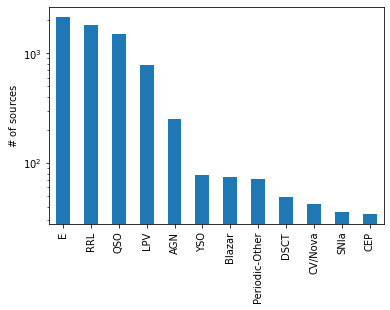

In [19]:
label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

#plotting the number of sources per class for the labeled set
class_counts = Counter(labels_paula['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

 ### Defining functions to plot the confusion matrix and the feature importance

In [20]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [24]:
rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]

df = labels_paula.join(features_paula,how='inner')
df = df.replace([np.inf, -np.inf], np.nan)

df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

df.head()



6909


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaemke,0.319945,0.266913,0.999845,0.999997,1.0,1.0,0.361111,0.375000,0.0,0.0,...,0.885476,0.998750,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,1.885743e-06,4.405883e-08
ZTF17aaafyya,0.376849,0.347666,1.000000,1.000000,1.0,1.0,0.421875,0.388889,0.0,0.0,...,0.781429,0.996250,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,2.254299e-06,3.267149e-08
ZTF17aaageae,0.218249,0.327319,1.000000,0.999997,1.0,1.0,0.400000,0.115385,0.0,0.0,...,0.760000,1.000000,0.023,0.629,1.937573,1.308573,2.133469,1.504469,6.688907e-05,6.721974e-05
ZTF17aaaivsr,0.344626,0.305270,0.999993,0.821926,1.0,1.0,0.384615,0.400000,0.0,0.0,...,0.780000,0.992012,-0.060,1.885,4.006276,2.121276,4.565984,2.680984,1.782890e-06,1.782890e-06
ZTF17aaaizej,0.660175,0.404425,1.000000,1.000000,1.0,1.0,0.317073,0.311111,0.0,0.0,...,0.840238,1.000000,0.009,2.871,4.185692,1.314692,4.359793,1.488793,4.163987e-08,6.982180e-05


In [26]:
Y_hierarchical = labels_paula['class_hierachical']
Y_original = labels_paula['class_original']

print(len(labels_paula['class_hierachical'].values))
print(len(labels_paula['class_original'].values))
X_hierarchical = df

X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

6909
6909
3927 1571 29


  ## Balanced random forest
  
  ### Top level: separating Periodic, Stochastic and Transients:

In [29]:
#Training first level of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first level performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)
        
# with open(model_first_layer, 'wb') as f:
#             pickle.dump(
#                 rf_model_hierarchical,
#                 f,
#                 pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9652677279305355
Balanced accuracy: 0.9704796601766487


[[  7   0   0]
 [  1 367  25]
 [  5  17 960]]
Normalized confusion matrix
[[100.   0.   0.]
 [  0.  93.   6.]
 [  1.   2.  98.]]


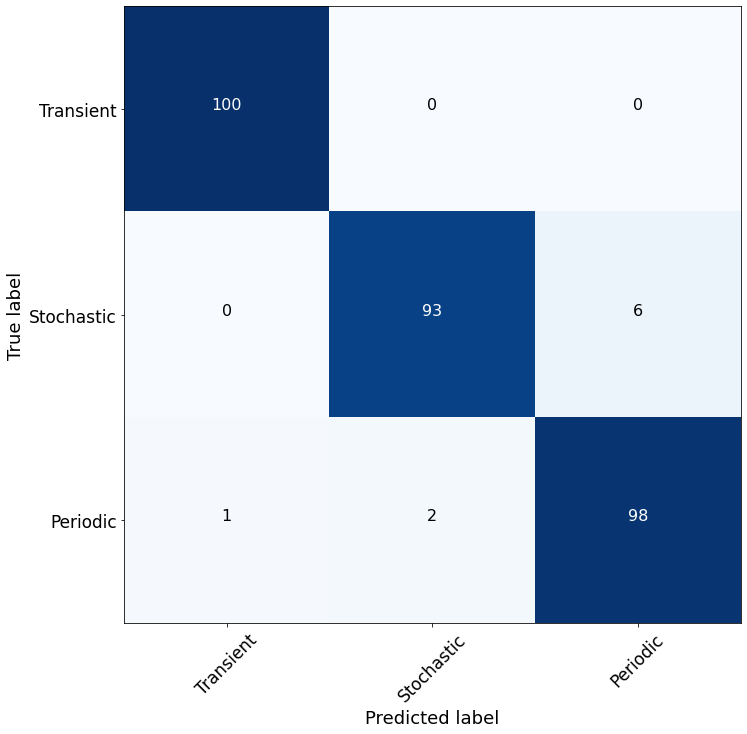

In [31]:

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.076
SPM_beta_1 & 0.051
SPM_tau_rise_2 & 0.042
SPM_tau_rise_1 & 0.036
positive_fraction_2 & 0.034
SPM_tau_fall_1 & 0.033
sgscore1 & 0.030
SPM_A_2 & 0.028
n_non_det_after_fid_1 & 0.027
SPM_A_1 & 0.027
SPM_chi_2 & 0.023
positive_fraction_1 & 0.023
SPM_chi_1 & 0.022
n_non_det_after_fid_2 & 0.020
SPM_beta_2 & 0.017
SPM_t0_1 & 0.016
g-W3 & 0.015
g-W2 & 0.015
max_diffmaglim_after_fid_2 & 0.015
ExcessVar_1 & 0.014
SPM_tau_fall_2 & 0.013
delta_mag_fid_2 & 0.012
r-W3 & 0.012
r-W2 & 0.011
GP_DRW_sigma_2 & 0.009
AndersonDarling_1 & 0.009
ExcessVar_2 & 0.009
AndersonDarling_2 & 0.009
LinearTrend_2 & 0.009
Q31_1 & 0.009


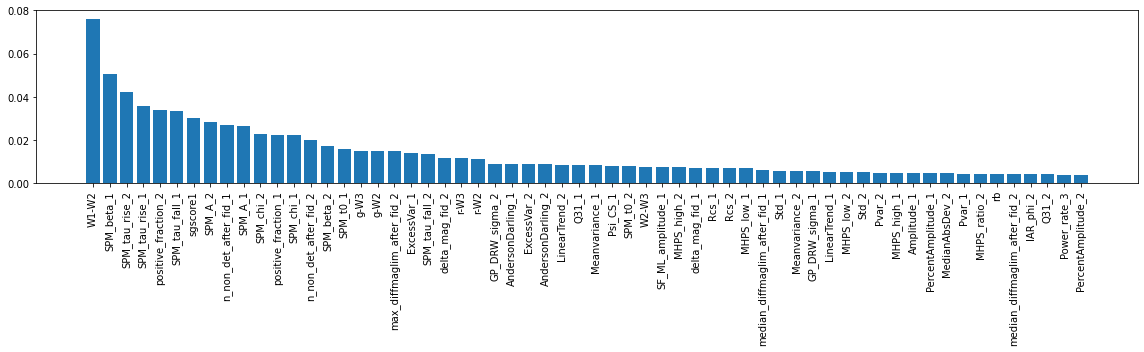

In [33]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, './feature_ranking_hierarchical_level.pdf')

  ### Periodic classifier

In [35]:
#Training Periodic classifier

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

# with open('./periodic_level_RF_model.pkl', 'wb') as f:
#             pickle.dump(
#                 rf_model_periodic,
#                 f,
#                 pickle.HIGHEST_PROTOCOL)

['CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


Multiband_period & 0.076
g-W2 & 0.037
g-r_mean & 0.029
g-W3 & 0.028
g-r_max_corr & 0.026
g-r_max & 0.022
GP_DRW_tau_1 & 0.022
delta_mag_fid_1 & 0.021
Amplitude_1 & 0.021
ExcessVar_1 & 0.020
g-r_mean_corr & 0.019
Meanvariance_1 & 0.019
PercentAmplitude_1 & 0.018
IAR_phi_1 & 0.017
Std_1 & 0.017
GP_DRW_sigma_1 & 0.016
r-W2 & 0.014
Q31_1 & 0.013
SF_ML_amplitude_1 & 0.013
GP_DRW_tau_2 & 0.010
SF_ML_gamma_1 & 0.010
W1-W2 & 0.010
Gskew_1 & 0.009
MHPS_ratio_1 & 0.009
r-W3 & 0.008
delta_period_1 & 0.008
Autocor_length_1 & 0.008
Harmonics_mag_5_2 & 0.008
W2-W3 & 0.007
MedianAbsDev_1 & 0.007


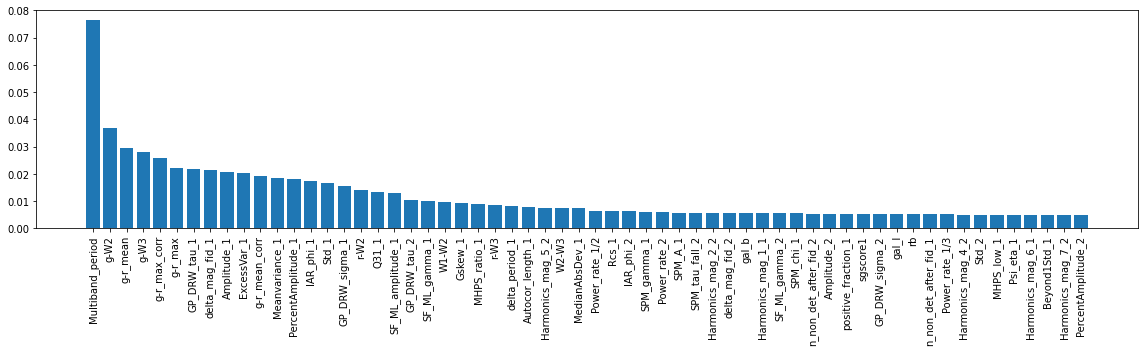

In [36]:
#plotting feature importance
# print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, './feature_ranking_periodic_level.pdf')

  ### Stochastic classifier

In [37]:
#Training Stochastic classifier

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO']


W1-W2 & 0.089
g-W2 & 0.050
g-W3 & 0.050
g-r_mean_corr & 0.049
g-r_max_corr & 0.048
g-r_mean & 0.040
sgscore1 & 0.037
SPM_A_2 & 0.032
delta_mag_fid_2 & 0.029
r-W2 & 0.026
gal_b & 0.024
g-r_max & 0.020
r-W3 & 0.020
ExcessVar_2 & 0.017
Meanvariance_2 & 0.017
GP_DRW_sigma_2 & 0.016
W2-W3 & 0.014
ExcessVar_1 & 0.013
Meanvariance_1 & 0.012
PercentAmplitude_1 & 0.012
delta_mag_fid_1 & 0.011
Pvar_2 & 0.011
SPM_A_1 & 0.010
PercentAmplitude_2 & 0.010
Std_2 & 0.010
Amplitude_2 & 0.009
Amplitude_1 & 0.009
Std_1 & 0.009
GP_DRW_tau_2 & 0.009
GP_DRW_sigma_1 & 0.008


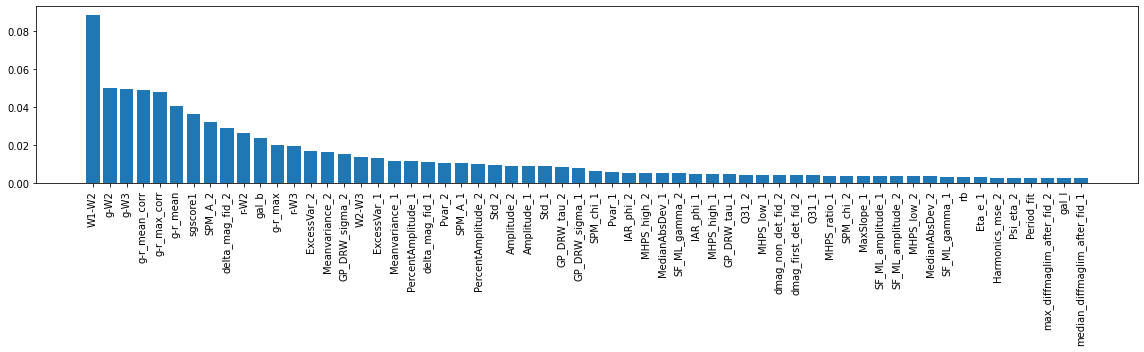

In [38]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, './feature_ranking_stochastic_level.pdf')

  ### Transient classifier

In [41]:
#Training Transient classifier

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [42]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, './feature_ranking_transient_level.pdf')

NameError: name 'features_transient' is not defined

 ## Putting al layers together  

In [43]:
# generating final probabilities

#multiplying probabilities of the top level with the other classifiers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]

NameError: name 'y_pred_proba_transient' is not defined